# <b>Real Estate Price Prediction

## <b>Importing Libraries

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.inspection import permutation_importance

## <b>Loading the Dataset

In [18]:
data = pd.read_csv('Dataset/NY-House-Dataset.csv')

## <b>Initial Data Exploration

In [19]:
print(data.head())
print(data.info())
print(data.describe())

                                         BROKERTITLE                TYPE  \
0        Brokered by Douglas Elliman  -111 Fifth Ave      Condo for sale   
1                                Brokered by Serhant      Condo for sale   
2                             Brokered by Sowae Corp      House for sale   
3                                Brokered by COMPASS      Condo for sale   
4  Brokered by Sotheby's International Realty - E...  Townhouse for sale   

       PRICE  BEDS       BATH  PROPERTYSQFT  \
0     315000     2   2.000000        1400.0   
1  195000000     7  10.000000       17545.0   
2     260000     4   2.000000        2015.0   
3      69000     3   1.000000         445.0   
4   55000000     7   2.373861       14175.0   

                                             ADDRESS                    STATE  \
0                               2 E 55th St Unit 803       New York, NY 10022   
1  Central Park Tower Penthouse-217 W 57th New Yo...       New York, NY 10019   
2                

## <b>Data Preprocessing

### <b>Handle Missing Values

In [20]:
imputer = SimpleImputer(strategy='median')
data['PRICE'] = imputer.fit_transform(data[['PRICE']])

### <b>Convert Categorical Variables

In [21]:
categorical_features = ['BROKERTITLE', 'TYPE', 'STATE', 'MAIN_ADDRESS', 'ADMINISTRATIVE_AREA_LEVEL_2', 'LOCALITY', 'SUBLOCALITY', 'STREET_NAME']
numerical_features = ['BEDS', 'BATH', 'PROPERTYSQFT', 'LATITUDE', 'LONGITUDE']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

### <b>Feature Engineering

In [22]:
data['PRICE_PER_SQFT'] = data['PRICE'] / data['PROPERTYSQFT']

## <b>Exploratory Data Analysis (EDA)

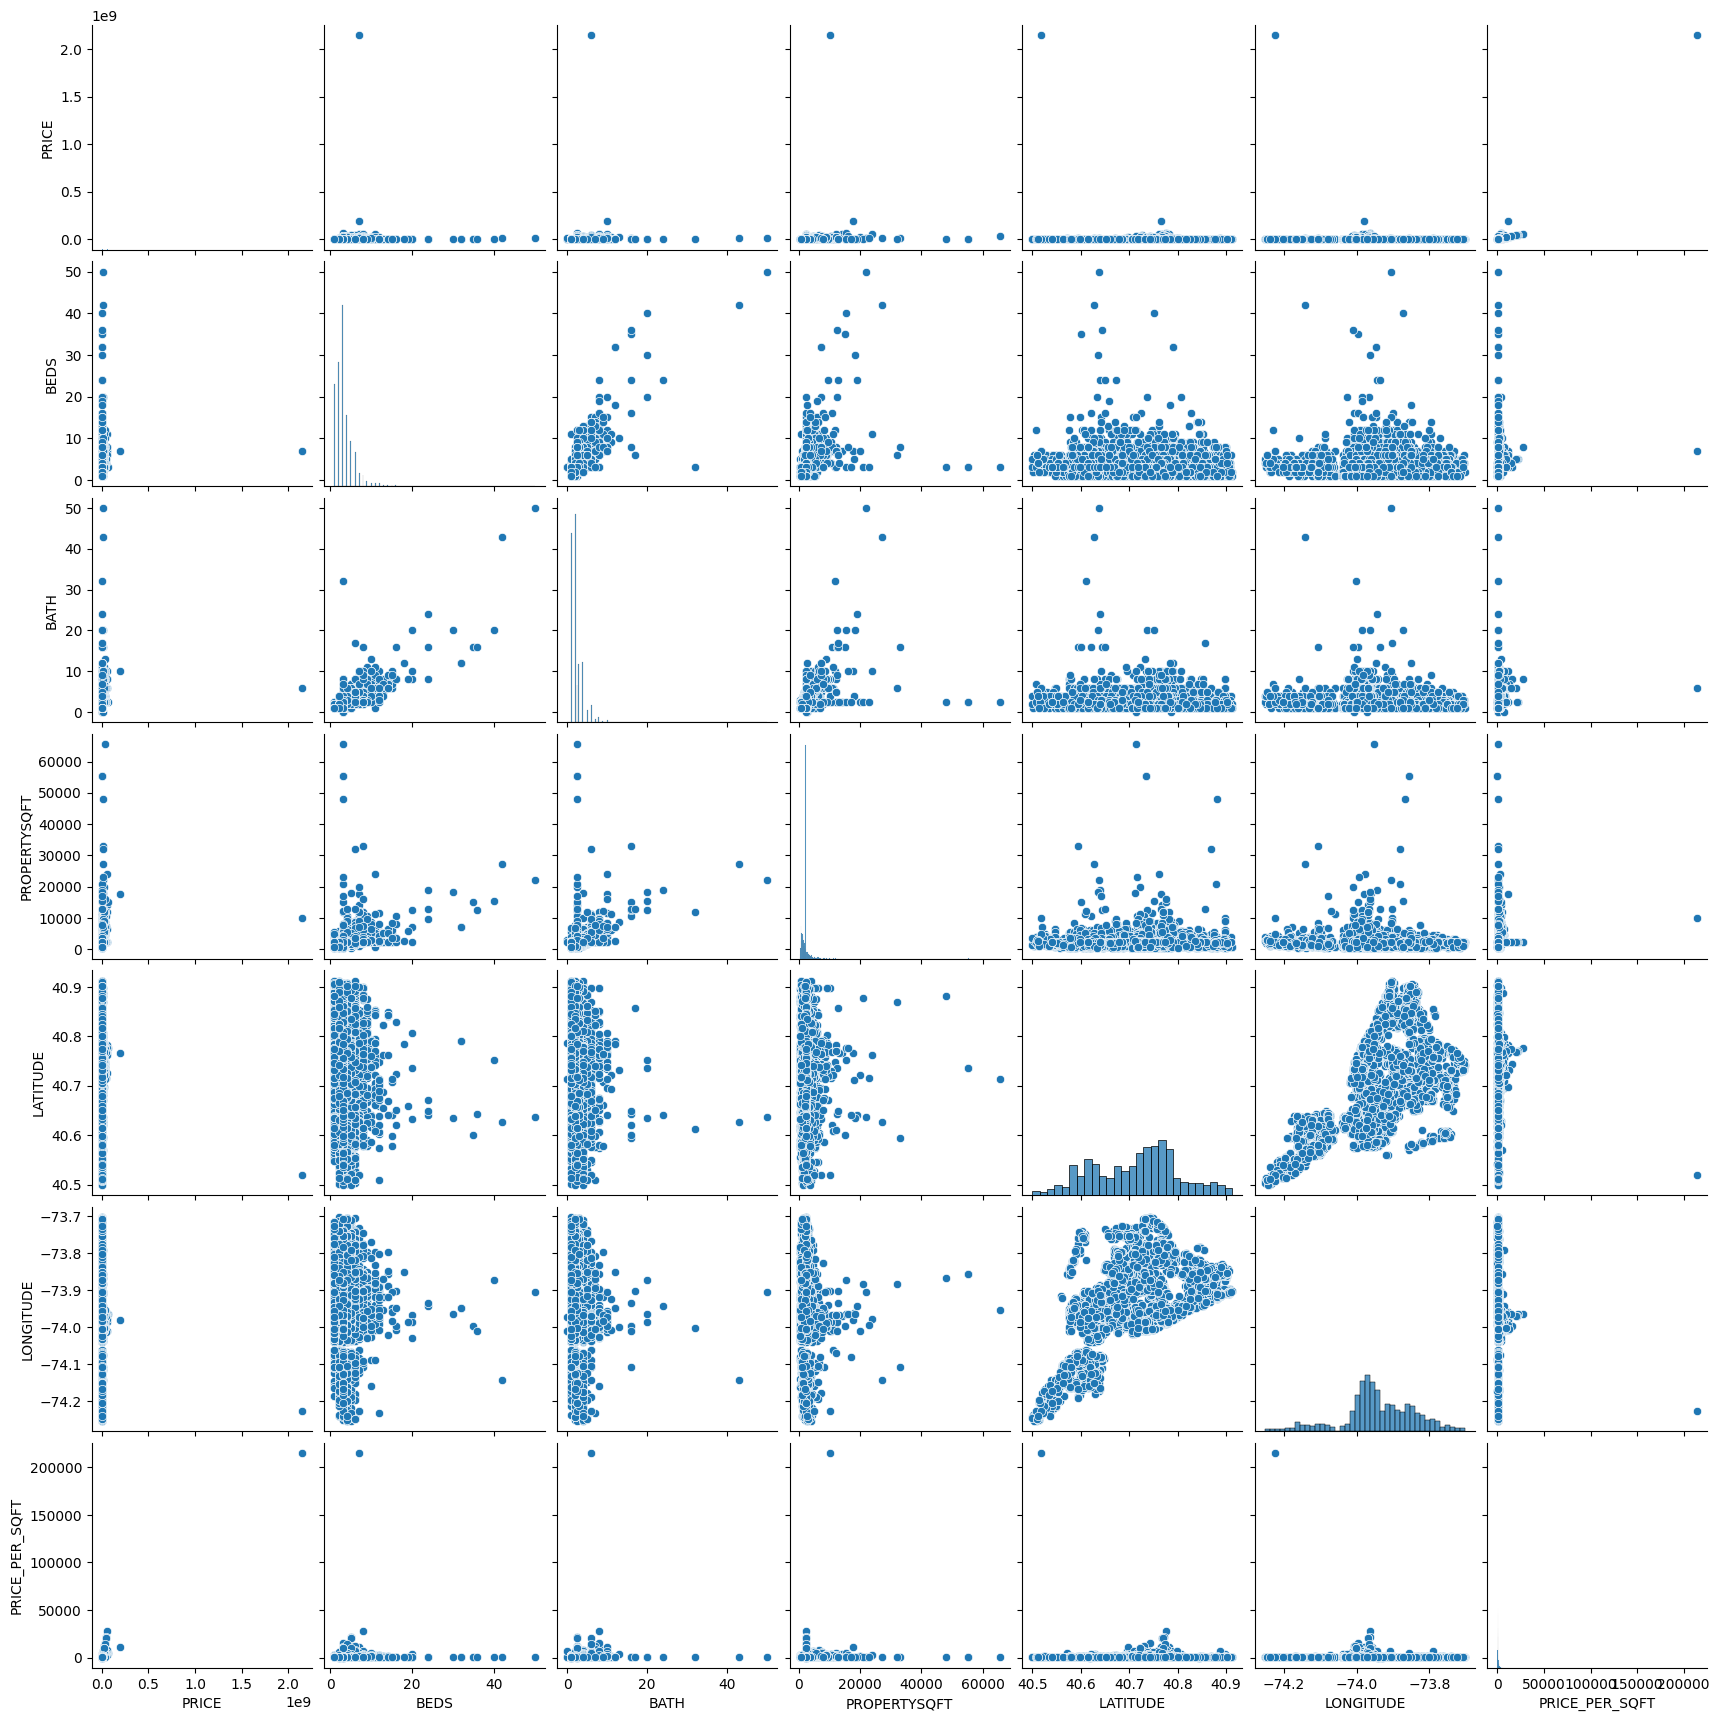

In [23]:
sns.pairplot(data)
plt.show()

## <b>Feature Selection

In [24]:
# Keeping only relevant features for simplicity
features = ['BEDS', 'BATH', 'PROPERTYSQFT', 'LATITUDE', 'LONGITUDE', 'PRICE_PER_SQFT']
target = 'PRICE'

## <b>Data Splitting

In [25]:
X = data[features]
y = data[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## <b>Scaling the Features

In [26]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## <b>Model Selection and Training

In [27]:
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42),
    'AdaBoost': AdaBoostRegressor(random_state=42)
}

# Training and Evaluating Models
for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    print(f'{name} - MAE: {mean_absolute_error(y_test, y_pred)}')
    print(f'{name} - RMSE: {np.sqrt(mean_squared_error(y_test, y_pred))}')
    print(f'{name} - R^2: {r2_score(y_test, y_pred)}')

Linear Regression - MAE: 3726859.022115505
Linear Regression - RMSE: 10227973.986584712
Linear Regression - R^2: -3.152099212670869
Random Forest - MAE: 142485.01581685746
Random Forest - RMSE: 1182678.508539582
Random Forest - R^2: 0.9444835224911338
Gradient Boosting - MAE: 268400.95475098497
Gradient Boosting - RMSE: 1262263.568220279
Gradient Boosting - R^2: 0.9367604766323067
AdaBoost - MAE: 2670679.302170562
AdaBoost - RMSE: 3266002.1118193944
AdaBoost - R^2: 0.5766286991214223


## <b>Hyperparameter Tuning

In [28]:
param_grid = {
    'Random Forest': {
        'n_estimators': [100, 200, 300],
        'max_depth': [10, 20, 30]
    },
    'Gradient Boosting': {
        'n_estimators': [100, 200, 300],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 7]
    }
}


## <b>Model Evaluation

In [29]:
best_models = {}
for name in param_grid:
    grid_search = GridSearchCV(models[name], param_grid[name], cv=3, scoring='neg_mean_squared_error')
    grid_search.fit(X_train_scaled, y_train)
    best_models[name] = grid_search.best_estimator_
    print(f'Best {name}: {grid_search.best_params_}')

Best Random Forest: {'max_depth': 10, 'n_estimators': 100}
Best Gradient Boosting: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 300}


## <b>Ensemble Learning

In [30]:
from sklearn.ensemble import VotingRegressor
voting_regressor = VotingRegressor(estimators=[
    ('rf', best_models['Random Forest']),
    ('gb', best_models['Gradient Boosting']),
    ('ada', models['AdaBoost'])
])
voting_regressor.fit(X_train_scaled, y_train)
y_pred_voting = voting_regressor.predict(X_test_scaled)
print(f'Voting Regressor - MAE: {mean_absolute_error(y_test, y_pred_voting)}')
print(f'Voting Regressor - RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_voting))}')
print(f'Voting Regressor - R^2: {r2_score(y_test, y_pred_voting)}')

Voting Regressor - MAE: 945317.3557775306
Voting Regressor - RMSE: 1489245.0184186976
Voting Regressor - R^2: 0.9119720060855531


## <b>Model Interpretation

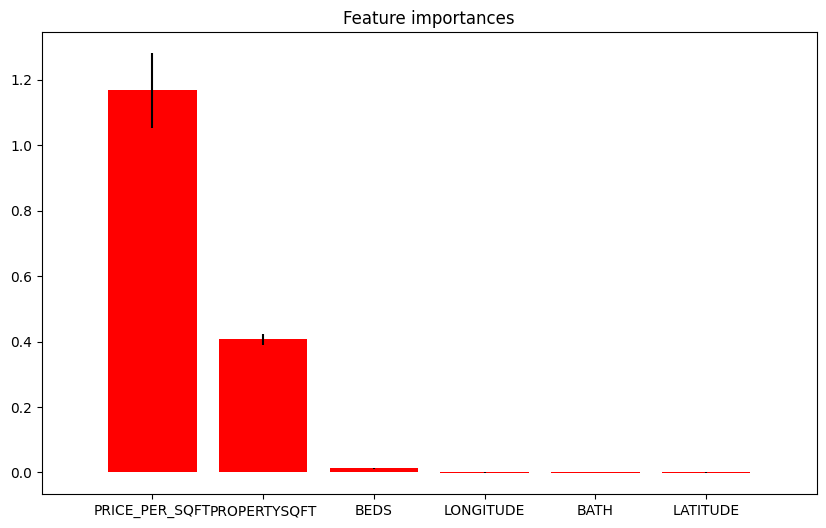

In [31]:
perm_importance = permutation_importance(voting_regressor, X_test_scaled, y_test)
feature_names = features
importances = perm_importance.importances_mean
std = perm_importance.importances_std
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices], color="r", yerr=std[indices], align="center")
plt.xticks(range(X_train.shape[1]), [feature_names[i] for i in indices])
plt.xlim([-1, X_train.shape[1]])
plt.show()

## <b>Saving the Model

In [32]:
import joblib


joblib.dump(voting_regressor, 'real_estate_price_predictor.pkl')

['real_estate_price_predictor.pkl']

## <b>Prediction on New Data

In [33]:
def predict_new_data(new_data):
    new_data_scaled = scaler.transform(new_data)
    return voting_regressor.predict(new_data_scaled)

# Example of prediction on new data
new_data = pd.DataFrame({
    'BEDS': [3],
    'BATH': [2],
    'PROPERTYSQFT': [1500],
    'LATITUDE': [40.7128],
    'LONGITUDE': [-74.0060],
    'PRICE_PER_SQFT': [1500/3]
})
prediction = predict_new_data(new_data)
print(f'Predicted Price: {prediction[0]}')

Predicted Price: 1686107.1011773096
